In [6]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import os

In [7]:
hf = h5py.File('2023053002_T101.h5')

In [8]:
volume_kspace = hf['kspace'][()]
print('Kspace shape:',volume_kspace.shape)
out = hf['reconstruction_rss'][()]
print('reconstruction rss shape:',out.shape)

Kspace shape: (18, 4, 256, 256)
reconstruction rss shape: (18, 256, 256)


In [17]:
import fastmri
from fastmri.data import transforms as T

def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16,8))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [12]:
slice_kspace = volume_kspace[8] # Choosing the 8-th slice of this volume
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

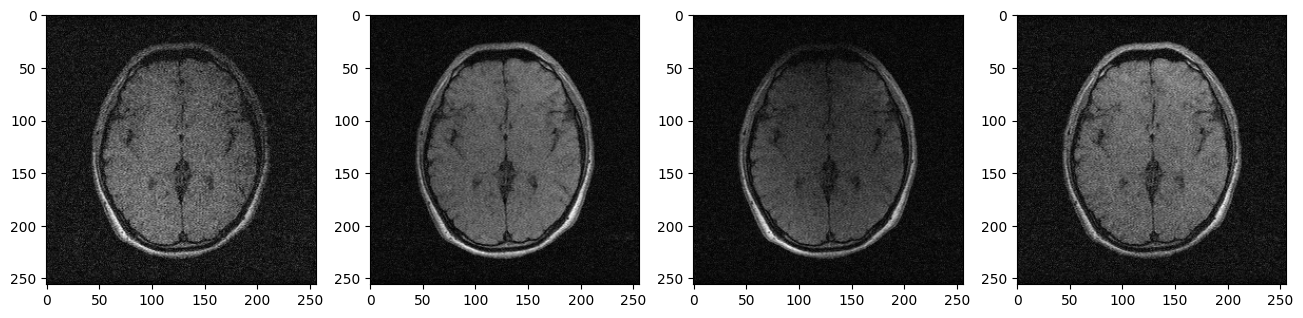

In [18]:
show_coils(slice_image_abs, [0, 1, 2, 3], cmap='gray')

In [19]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

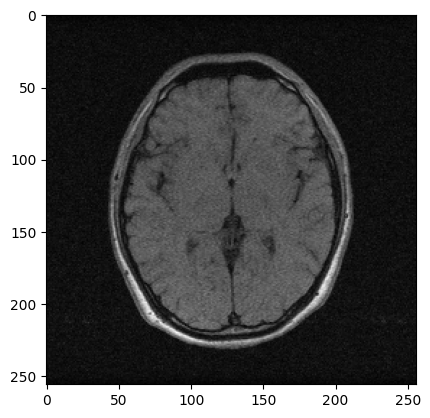

In [20]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

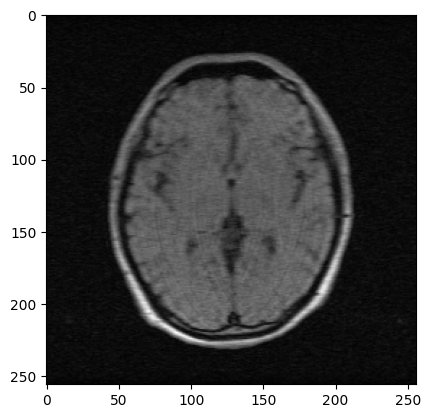

In [82]:
from fastmri.data.subsample import EquispacedMaskFractionFunc
mask_func = EquispacedMaskFractionFunc(center_fractions=[0.25], accelerations=[3])  # Create the mask function object
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

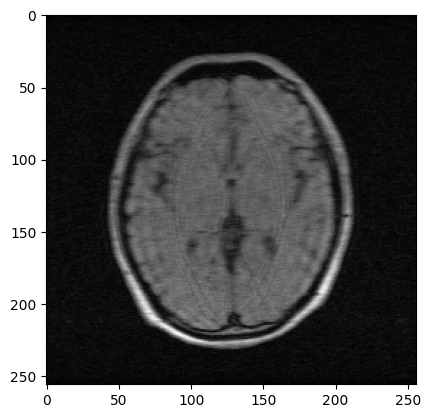

In [83]:
from fastmri.data.subsample import EquispacedMaskFractionFunc
mask_func = EquispacedMaskFractionFunc(center_fractions=[0.2], accelerations=[3])  # Create the mask function object
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def add_rician_noise(image, noise_std):
    # """
    # Add Rician noise to an image.
    
    # Parameters:
    # - image: 2D numpy array, the input MRI image
    # - noise_std: float, standard deviation of the Gaussian noise
    
    # Returns:
    # - noisy_image: 2D numpy array, the image with added Rician noise
    # """
    # # Generate Gaussian noise
    # noise_real = np.random.normal(0, noise_std, image.shape)
    # noise_imag = np.random.normal(0, noise_std, image.shape)
    
    # # Calculate the Rician noise
    # noise_magnitude = np.sqrt(noise_real**2 + noise_imag**2)
    
    # # Add Rician noise to the image
    # noisy_image = np.sqrt(image**2 + noise_magnitude**2)
    
    # return noisy_image
    image_min = image.min()
    image_max = image.max()
    normalized_image = (image - image_min) / (image_max - image_min)
    
    # Generate Gaussian noise
    noise_real = np.random.normal(0, noise_std, normalized_image.shape)
    noise_imag = np.random.normal(0, noise_std, normalized_image.shape)
    
    # Calculate the Rician noise magnitude
    noise_magnitude = np.sqrt(noise_real**2 + noise_imag**2)
    
    # Add Rician noise to the normalized image
    noisy_normalized_image = np.sqrt(normalized_image**2 + noise_magnitude**2)
    
    # Rescale back to original intensity range
    noisy_image = noisy_normalized_image * (image_max - image_min) + image_min
    
    return noisy_image

In [137]:
image = np.abs(sampled_image_rss.numpy())
noise_std = .12
image_std = add_rician_noise(image, noise_std)

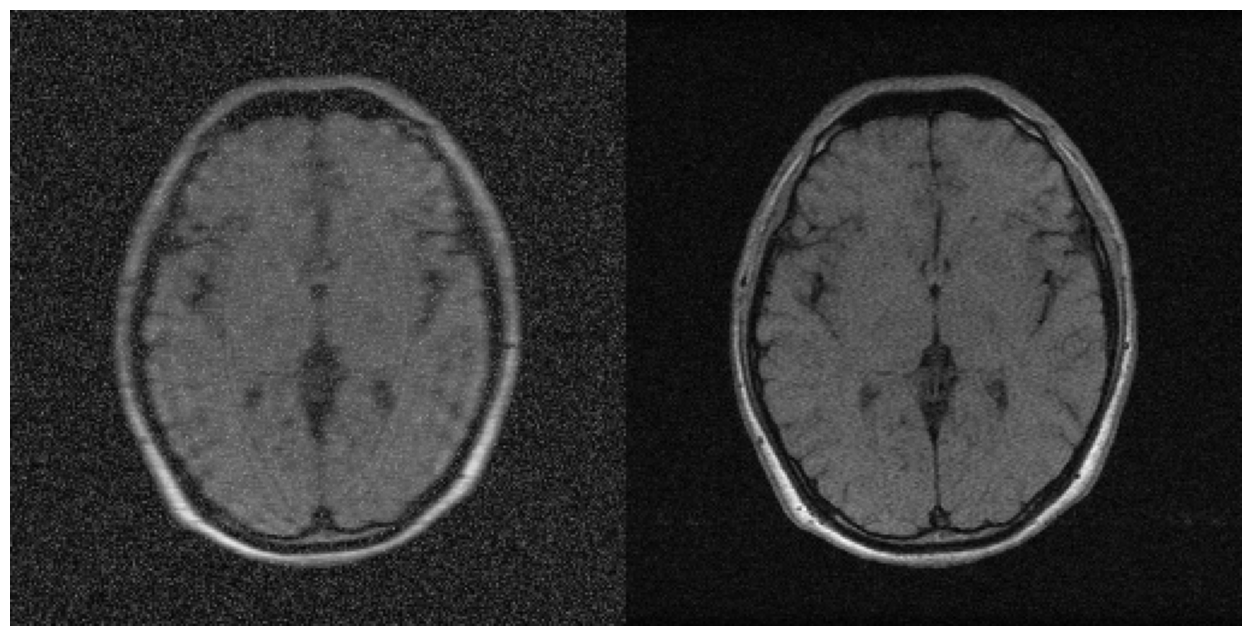

In [139]:
plt.figure(figsize=(16,8))
plt.imshow(np.hstack((image_std, np.abs(slice_image_rss.numpy()))), cmap='gray')
plt.axis('off')
plt.show()